In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# duality
primial problem을 lagrange dual problem으로 바꿔서 푸는 방법을 알아보고 의미를 분석해보자.  
아래와 같은 optimization problem이 있다.
$$
\underset{x\in \mathbb{R}}{min} \; x^2+1 \;\;subject \; to \; (x-2)(x-4) \leq 0
$$

Text(3, 1.5, 'local min')

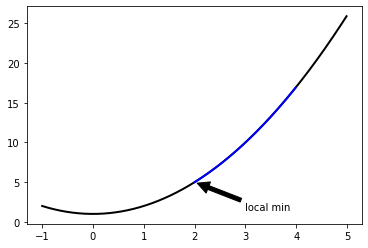

In [2]:
def func(x):
    return x**2 + 1

x = np.arange(-1, 5, 0.01)
feasible_x = np.arange(2, 4, 0.01)

plt.plot(x, func(x), lw=2, color='k')
plt.plot(feasible_x, func(feasible_x), lw=2, color='b')

plt.annotate('local min', xy=(2, func(2)), xytext=(3, 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

위 문제의 경우 feasible region에서 $p^{*} = 5$ 이다.  
이 때 dual problem의 해 $d^{*}$ 와 일치하는지 알아보자. 
dual function은 Lagrange 함수의 하한을 의미하며 아래와 같이 정리할 수 있다.
$$
\begin{align}
g(\lambda) &= \underset{x}{min} \; L(x,\lambda) \\
&= \underset{x}{min} \; (1+\lambda)x^{2} - 6 \lambda x + 1 + 8 \lambda
\end{align}
$$
그래프에서 Lagrange 함수의 기하학적인 형태를 살펴보자.  
$\lambda$를 상수로 두고 0에서 2까지 증가시켜가며 2차원 상에서 그래프를 그리면 다음과 같다.

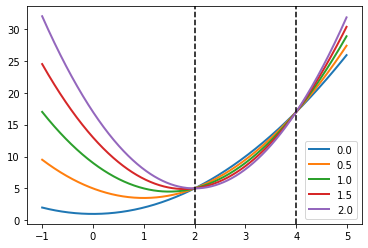

In [3]:
def lagrange(a, b):
    return (1 + b)*a**2 - 6*b*a + 1 + 8*b

for b in np.arange(0, 2.5, 0.5):    
    plt.plot(x, lagrange(x, b), lw=2, label = str(b))
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=4, color='k', linestyle='--')
plt.legend()    

Lagrange함수는 feasible region내에서 $\lambda$가 증가할수록 원함수보다 작아지며 극값이 점점 왼쪽에서 오른쪽으로 이동하는 경향을 보인다.   
Lagrange 함수를 x 에 대해서 미분하여 최소점을 찾고 이를 다시 대입하면 다음과 같다.
$$
\begin{align}
\nabla_{x} L(x,\lambda) &= 2(1 + \lambda) x - 6 \lambda = 0 \\
x &= \frac{3\lambda}{1+\lambda} \\
g(\lambda) &= \begin{cases}
\frac{-9 \lambda^{2}}{1+\lambda} + 1 + 8 \lambda & \lambda > -1 \\
-\infty & \lambda \leq -1
\end{cases}
\end{align}
$$
여기서 dual problem은 아래와 같다.

$$
\underset{\lambda}{max} \; g(\lambda) \; s.t. \; \lambda > 0
$$
3차원 그래프에서 이를 다시 살펴보자.

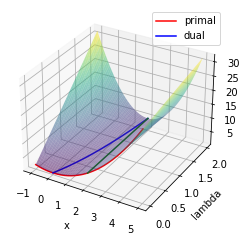

In [4]:
def dualfunc(l):
    return (-9 * (l**2) / (1 + l)) + 1 + 8 * l
def getx(l):
    return 3 * l / (1 + l)

ax = plt.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('lambda')

x = np.arange(-1, 5, 0.01)
l = np.arange(0, 2, 0.01)
x, l = np.meshgrid(x,l)
ax.plot_surface(x, l, lagrange(x,l), cmap=cm.viridis, alpha=0.5)
# ax.contour(x, l, lagrange(x,l), zdir='z', offset=0,
#            levels=20, cmap=cm.viridis, alpha=1)

x = np.arange(-1, 5, 0.01)
l = np.arange(0, 2, 0.01)
ax.plot(x, np.zeros_like(x), func(x), 'r', label='primal')
ax.plot(getx(l), l, dualfunc(l), 'b', label='dual')
ax.plot(np.ones_like(l)*2, l, lagrange(2,l), 'g')
plt.legend()

빨간색 선이 primary problem의 함수이고 Lagrange 함수를 mesh grid로 표현했다.  
dual 함수는 파란색 선에 해당되며 dual problem의 해는 $x = 2, \lambda = 2$가 된다.  
이 경우 $p^{*} = d^{*} = 5$ 이고 strong duality를 만족한다.

# Implementation
위에서는 라그랑주 함수를 직접 미분하여 dual 함수를 찾았다.  
이후 dual 함수의 optimal을 찾아서 문제를 풀었다.  
이번절에서는 Gradient decent알고리즘을 통해 dual optimal problem을 푸는 것을 구현해보자.  

In [5]:
def func(x):
    return x**2 + 1
def ineconstr(x):
    return (x-2)*(x-4)
def lagrange(x,l):
    return func(x) + l*ineconstr(x)

optimal_multiplier : [1.99999962], dual_optimal : [5.]


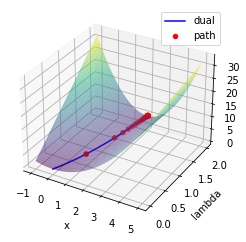

In [6]:
def gradient(f, x, y=None, epsilon=1e-7):
    """ numerically find gradients. 
    x: shape=[n] """
    
    grad = np.zeros_like(x, dtype=float)
    for i in range(len(x)):
        h = np.zeros_like(x, dtype=float)
        h[i] = epsilon
        if y is None:
            grad[i] = (f(x + h) - f(x - h)) / (2 * h[i])
        else:
            grad[i] = (f(x + h, y) - f(x - h, y)) / (2 * h[i])
    return grad

init= np.array([3])
# print(gradient(lagrange,init,3))

def grad_decent(f, init, step, y=None, lr=0.001, history=False):
    x = init
    memo = [x]
    for i in range(step):
        if y is None:
            grad = gradient(f, x)        
        else:
            grad = gradient(f, x, y)
        x = x - lr * grad
        if history: memo.append(x)    
    if not history: return x
    return x, np.array(list(zip(*memo)))

xs = []
ls = np.arange(0,2,0.1)
for l in ls:
    ans, history = grad_decent(lagrange, init, y=l, step=4000, lr=0.001, history=True)
    xs.append(ans)
xs = np.array(xs).flatten()

x = np.arange(-1, 5, 0.01)
l = np.arange(0, 2, 0.01)
x, l = np.meshgrid(x,l)
ax = plt.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('lambda')
ax.plot_surface(x, l, lagrange(x,l), cmap=cm.viridis, alpha=0.5)
ax.plot(xs, ls, lagrange(xs,ls), 'b', label='dual')

primary_init = np.array([3])
dual_init= np.array([0.5])
# dual_function = lambda e: lagrange(grad_decent(lagrange, init=primary_init, y=e, step=100, lr=0.1, history=True)[0],e)
# neg_dual_function = lambda e: -dual_function(e)

xs = [primary_init]
def neg_dual_function(e):
    p_ans, hist = grad_decent(lagrange, init=xs[-1], y=e, step=100, lr=0.2, history=True)
    xs.append(p_ans)
    return -lagrange(p_ans,e)

ans, history = grad_decent(neg_dual_function, dual_init, step=100, lr=0.2, history=True)
print('optimal_multiplier : {}, dual_optimal : {}'.format(ans,-neg_dual_function(ans)))

zs = []
for h in history.flatten():
    z = -neg_dual_function(h)
    zs.append(z)
zs = np.concatenate(zs, axis=0)
xs = getx(history.flatten())
ax.scatter(xs, history.flatten(), zs, color='r', label='path')

ax.legend()